# Working with spectral data from the data archive
This Notebook discusses how to interact with the open data archive using the roguewavespectrum package. To install the package, use the following command: `pip install roguewavespectrum` and for (draft) documentation see https://sofarocean.github.io/oceanwavespectrum/roguewavespectrum.html.

To work with data from the spectral data archive, stored on s3 as a zarr archive, we first have to load the archive as a remote xarray dataset.


In [10]:
import xarray as xr
dataset = xr.open_dataset( "s3://sofar-spotter-archive/spotter_data_spectra_zarr/", engine="zarr")

With the data loaded, we can now use the dataset to create a `BuoySpectra` object from the `roguewavespectrum` package as follows:

In [11]:
from roguewavespectrum import BuoySpectrum
spectra = BuoySpectrum.from_trajectory_dataset(dataset)

where we used the special constructor method designed for trajectory datasets. We are now ready to proceed and work with the data. First, lets explore
the buoy spectrum object a bit. To see which buoys are available in the dataset, we can use the `keys` attribute (just like a dictionary):

In [12]:
buoy_ids = spectra.keys()[0:2]
print( buoy_ids )

['SPOT-010001', 'SPOT-010006']


In fact the `BuoySpectrum` object acts much like  a dictionary, e.g. we can loop over keys:

In [13]:
# Print the ids
for buoy_id in spectra:
    print('Buoy id: ', buoy_id)

Buoy id:  SPOT-010001
Buoy id:  SPOT-010006
Buoy id:  SPOT-010007
Buoy id:  SPOT-010008
Buoy id:  SPOT-010009
Buoy id:  SPOT-010010
Buoy id:  SPOT-010013
Buoy id:  SPOT-010015
Buoy id:  SPOT-010016
Buoy id:  SPOT-010018
Buoy id:  SPOT-010021
Buoy id:  SPOT-010025
Buoy id:  SPOT-010031
Buoy id:  SPOT-010032
Buoy id:  SPOT-010034
Buoy id:  SPOT-010036
Buoy id:  SPOT-010037
Buoy id:  SPOT-010038
Buoy id:  SPOT-010039
Buoy id:  SPOT-010040
Buoy id:  SPOT-010042
Buoy id:  SPOT-010043
Buoy id:  SPOT-010044
Buoy id:  SPOT-010046
Buoy id:  SPOT-010047
Buoy id:  SPOT-010048
Buoy id:  SPOT-010050
Buoy id:  SPOT-010051
Buoy id:  SPOT-010052
Buoy id:  SPOT-010053
Buoy id:  SPOT-010054
Buoy id:  SPOT-010055
Buoy id:  SPOT-010056
Buoy id:  SPOT-010057
Buoy id:  SPOT-010058
Buoy id:  SPOT-010059
Buoy id:  SPOT-010061
Buoy id:  SPOT-010062
Buoy id:  SPOT-010063
Buoy id:  SPOT-010065
Buoy id:  SPOT-010067
Buoy id:  SPOT-010068
Buoy id:  SPOT-010069
Buoy id:  SPOT-010070
Buoy id:  SPOT-010071
Buoy id:  

Note that at this point, other than the general discription and buoy_id- no data has been loaded from the server. We can access the data for a specific buoy using the key:

In [14]:
# Get the data for a specific buoy
buoy_spectrum = spectra[buoy_ids[0]]

When we access the data for a specific buoy we get a spectrum object that contains all the data for that buoy alone. Because we are using Zarr  this is the first time any data is actually downloaded (i.e. accessing the property will trigger download of all data for that buoy). At this moment we may also want to save the data locally, so that we can access it later without having to download it again. This can be done using the `to_netcdf` metho, which saves the data locally using the netcdf format using CF conventions (note that this is a convenient method to download the dataset locally).

In [17]:
# save locally
buoy_spectrum.to_netcdf('~/spectrum.nc')

If we wanted to load the data at a later stage we could do so as follows:

In [18]:
buoy_spectrum = BuoySpectrum.from_netcdf('~/spectrum.nc')


Now Let's plot some data for the buoy. E.g. for example lets see what the significant wave height and period look like:

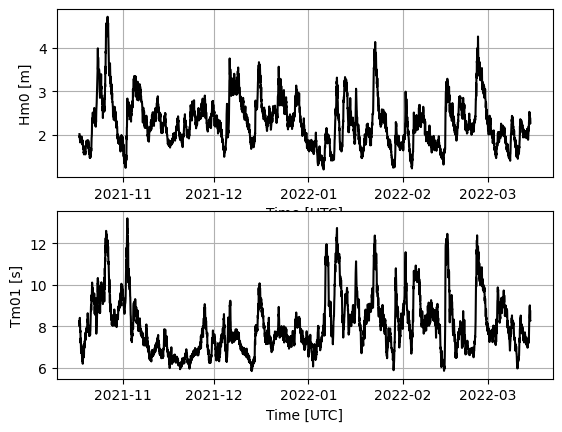

In [19]:
import matplotlib.pyplot as plt
plt.subplot(2,1,1)
plt.plot( buoy_spectrum.time, buoy_spectrum.hm0(),'k')
plt.ylabel('Hm0 [m]')
plt.xlabel('Time [UTC]')
plt.grid('on')

plt.subplot(2,1,2)
plt.plot( buoy_spectrum.time, buoy_spectrum.mean_period(),'k')
plt.ylabel('Tm01 [s]')
plt.xlabel('Time [UTC]')
plt.grid('on')

It looks like a swell system hit the buoy early November 2021. Let's see if we can plot a spectrum for that period

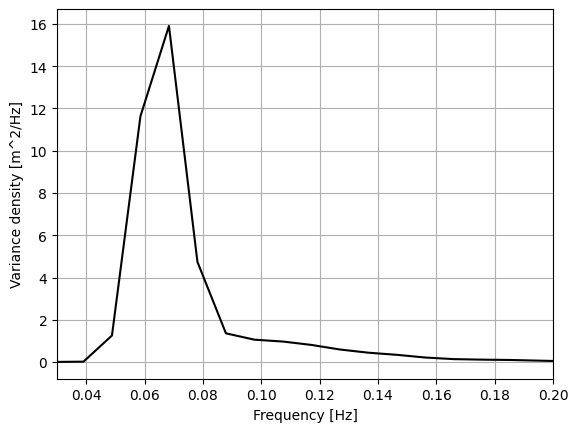

In [20]:
from datetime import datetime

#Select the buoy
spec1d = buoy_spectrum.sel(time=datetime(2021,11,2,13), method='nearest')

# And plot the spectrum
plt.plot(spec1d.frequency, spec1d.variance_density,'k')
_ = plt.xlabel('Frequency [Hz]')
_ = plt.ylabel('Variance density [m^2/Hz]')
plt.xlim([0.03,0.2])
plt.grid('on')

Given the absence of a well developped tail this does look like a swell spectrum, though it is fairly wide in frequency space. I suspect the buoy was located close by the generating storm and these are the early fore-runners of the swell system. Lets look at the directional spectrum for this buoy

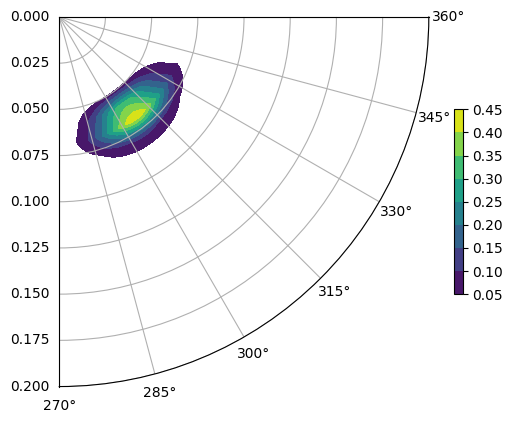

In [21]:
import numpy as np
# Create a directional spectrum with 360 directions. Note that this uses the MeM2 method to estimate the directional spectrum from buoy data.
spec2d = spec1d.as_frequency_direction_spectrum(number_of_directions=360)

# Plotting function
def plot_polar(ax,spectrum2D):
    theta = np.deg2rad(spectrum2D.direction())
    im = ax.contourf(theta, spectrum2D.frequency, spectrum2D.values, cmap='viridis', levels=np.arange(0.05,0.5,0.05))
    ax.set_xlim([1.5*np.pi,2*np.pi])
    ax.set_ylim([0,0.2])
    ax.set_theta_zero_location("E")
    ax.grid('on')
    plt.colorbar(im,shrink=0.5)

fig, ax = plt.subplots(1,1,subplot_kw=dict(projection='polar'))
plot_polar(ax,spec2d)

The spectrum is fairly narrow in directional space as well, and the waves are travelling to the SE.

# Working with the full dataset
Up until know we restricted ourselves to data from a single buoy, and a spectrum at a single time. However, all commands work on the full dataset as well. However, the operations will be slow- as the full dataset is quite large and we are working with a remote dataset.

For example, we can plot the rms wave height for all buoys versus mean period as follows (**this will take 5-10 minutes to complete**):


Text(0, 0.5, 'RMS wave height [m]')

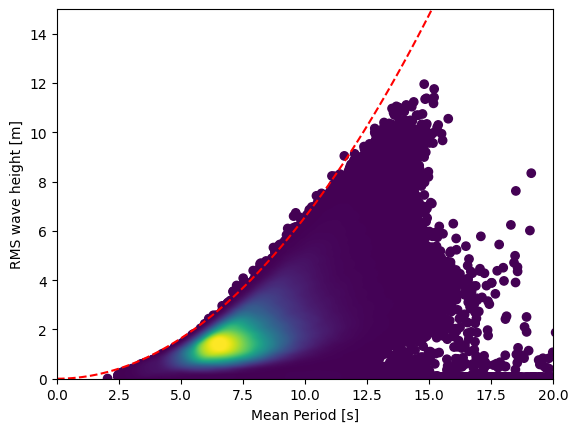

In [22]:
import matplotlib.pyplot as plt
import numpy
from scipy.interpolate import interpn

# lets plot
_, ax = plt.subplots(1,1)
bins = 100

# ** Here we get the data **
x = spectra.mean_period()
y = spectra.hrms()

# ** The rest is just plot generation **.
msk = numpy.isfinite(x) & numpy.isfinite(y) & (x > 0) & (y > 0)
x = x[msk]
y =y[msk]

data , x_e, y_e = numpy.histogram2d( x, y, bins = bins, density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , numpy.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

#To be sure to plot all data
z[numpy.where(numpy.isnan(z))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

_ = ax.scatter( x, y, c=z )
plt.xlim( (0,20) )
plt.ylim((0, 15))

# Add a parametric line
# Parametric line assuming mean breaking steepness of 0.042 - see Holthuijsen and Herbers, 1986.
hh86 = 0.042*np.linspace(0,20,100)**2 * 9.81 / (2*np.pi)
plt.plot( np.linspace(0,20,100),hh86,'r--',label='steepness = 0.042 (Holthuijsen and Herbers, 1986)')
plt.xlabel('Mean Period [s]')
plt.ylabel('RMS wave height [m]');